In [ ]:
#import os

#codepath = 'topy_test/topy/scripts/optimise.py'
#inputpath = 'topy_test/topy/examples/mbb_beam/beam_2d_reci.tpd'

#command = 'python ' + codepath + ' ' + inputpath
#os.system(command)

In [1]:
import tpd
import os
import topy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#codepath = 'topy_test/topy/scripts/optimise.py'
inputpath = 'topy_test/topy/examples/mbb_beam/beam_2d_reci.tpd'
#inputpath = 'topy_test/topy/examples/dogleg/dogleg_3d_etaopt_gsf.tpd'

In [ ]:
t = topy.Topology()
t.load_tpd_file(inputpath)
t.set_top_params()
topy.optimise(t)

In [ ]:
os.system('convert -delay 35 iterations/*.png iterations/anim.gif')

In [ ]:
t.topydict

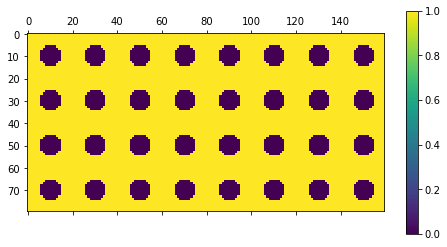

In [3]:
# 2D spherical lattice

domainSz = np.array([160, 80]) # in mm

cellSz = np.array([20, 20]) # in mm
numCells = (domainSz//cellSz).astype(int) # TODO: ensure domainSz is divisible by cellSz

voxelSz = np.array([1, 1]) # in mm
numVoxels = (cellSz//voxelSz).astype(int) # in each cell/unit

paramsDim = 1 # number of parameters for each cell
params = 5*np.ones(np.append(numCells, paramsDim))

# origin coordinates of cells
x_c, y_c = np.meshgrid(range(numCells[0])*cellSz[0], 
                    range(numCells[1])*cellSz[1], indexing='ij')

# voxel center coordinates relative to cell origin
x_v, y_v = np.meshgrid(range(numVoxels[0])*voxelSz[0] + voxelSz[0]/2, 
                    range(numVoxels[1])*voxelSz[1] + voxelSz[1]/2, indexing='ij')

field = np.zeros(numCells*numVoxels)
holes = np.zeros((np.prod(numCells), 2)) # hole coordinates in the cells, only for this type of cells
hh = 0
# TODO: make more efficient by doing vectorized computations outside loop
for i in range(numCells[0]):
    for j in range(numCells[1]):
        p = params[i, j]
        # voxel center global coordinates
        x = x_v + x_c[i, j]
        y = y_v + y_c[i, j]
        # cell center coordinates
        xx = x_c[i, j] + cellSz[0]/2
        yy = y_c[i, j] + cellSz[1]/2
        holes[hh] = [xx, yy]
        hh += 1
        # calculate distance field
        cell = np.sqrt((x - xx)**2 + (y - yy)**2) - p
        field[i*numVoxels[0]:(i+1)*numVoxels[0], 
              j*numVoxels[1]:(j+1)*numVoxels[1]] += cell
        
plt.matshow(field.T>=0)
plt.colorbar()
plt.show()

In [ ]:
binimg = field >= 0
x = np.sort(np.ravel_multi_index(np.where(binimg == False), domainSz))
#print(x)

In [ ]:
field.size

In [ ]:
N_elem = np.prod(binimg.shape)
print(len(x))
vol_frac = (N_elem - len(x))*1./N_elem
print(vol_frac)

In [4]:
config = tpd.minimal_tpd_dict()
config['PROB_NAME'] = 'sph_lat_test'
config['NUM_ELEM_X'] = domainSz[0]
config['NUM_ELEM_Y'] = domainSz[1]
config['VOL_FRAC'] = np.count_nonzero(field >= 0)*1./field.size
config['NUM_ITER'] = 10
config['PASV_ELEM'] = tpd.passive_elems(field >= 0)
config['FXTR_NODE_Y'] = '1|81'
config['FXTR_NODE_X'] = '1|81'
config['LOAD_NODE_Y'] = '12961'
config['LOAD_VALU_Y'] = '-1'

In [5]:
t = topy.Topology()
t.load_config_dict(config)
t.set_top_params()

In [ ]:
t.topydict

In [6]:
topy.optimise(t)

In [ ]:
t.df.shape

In [ ]:
plt.matshow(t.df)
plt.colorbar()
plt.show()

In [ ]:
t.fea()
t.sens_analysis()

In [8]:
dis = t.d.reshape((161, 81, 2))

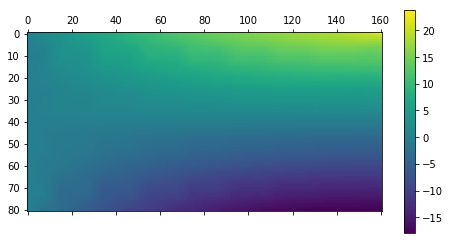

In [9]:
plt.matshow(dis[:, :, 0].T)
plt.colorbar()
plt.show()

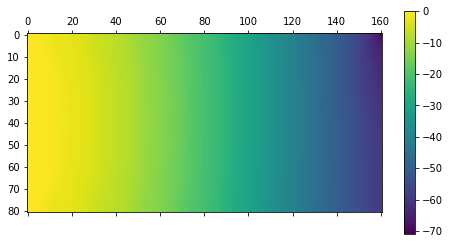

In [10]:
plt.matshow(dis[:, :, 1].T)
plt.colorbar()
plt.show()